In [13]:
import os
os.chdir("../")
%pwd

'd:\\AI\\NLP\\HandsOn\\sentiment-analysis'

# Advanced Modeling:

In [23]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np

# Load the model and tokenizer
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# Define labels for sentiment
labels = ["bad", "neutral",  "good"]

def predict_sentiment(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    
    # Get model predictions
    outputs = model(**inputs)
    scores = outputs.logits.detach().numpy()
    probabilities = torch.nn.functional.softmax(torch.tensor(scores), dim=-1)
    
    # Determine the sentiment
    sentiment_index = np.argmax(probabilities.numpy(), axis=1)[0]
    sentiment = labels[sentiment_index]
    confidence = probabilities[0][sentiment_index].item()
    
    return sentiment, confidence


In [15]:
# Simple interactive demo
if __name__ == "__main__":
    print("Sentiment Analysis Demo")
    print("Type 'exit' to quit the demo.")
    while True:
        text = input("\nEnter text to analyze: ")
        if text.lower() == 'exit':
            print("Exiting the demo. Goodbye!")
            break
        sentiment, confidence = predict_sentiment(text)
        print(f"Sentiment: {sentiment} (Confidence: {confidence:.2f})")

Sentiment Analysis Demo
Type 'exit' to quit the demo.


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Sentiment: Positive (Confidence: 0.95)
Sentiment: Negative (Confidence: 0.88)
Sentiment: Neutral (Confidence: 0.79)
Sentiment: Negative (Confidence: 0.63)
Exiting the demo. Goodbye!


----

### Appling the same thing on our data that we have:

In [36]:
import pandas as pd
data = pd.read_csv(r"D:\AI\NLP\HandsOn\sentiment-analysis\artifacts\feature_transformation\20250116_043222\test_split.csv",index_col=0)
data = data.head(50)

In [38]:
data.head(3)

,tweets,labels,processed_text,text_length
Unnamed: 0,,,,
162912,How will ChatGPT affect the Web3 space? Indust...,bad,chatgpt affect web3 space industri answer,104
77419,Thank you ChatGPT 🥲 https://t.co/zc3V7LZyhk ht...,neutral,thank chatgpt,67
32239,ChatGPT prompt: “Write a letter from Demeter t...,neutral,chatgpt prompt write letter demet hade form co...,144


In [39]:
data["data_sentiment"]  = data["tweets"].apply(predict_sentiment)

In [40]:
data["sentiment_label"] = data["data_sentiment"].apply(lambda x: x[0])

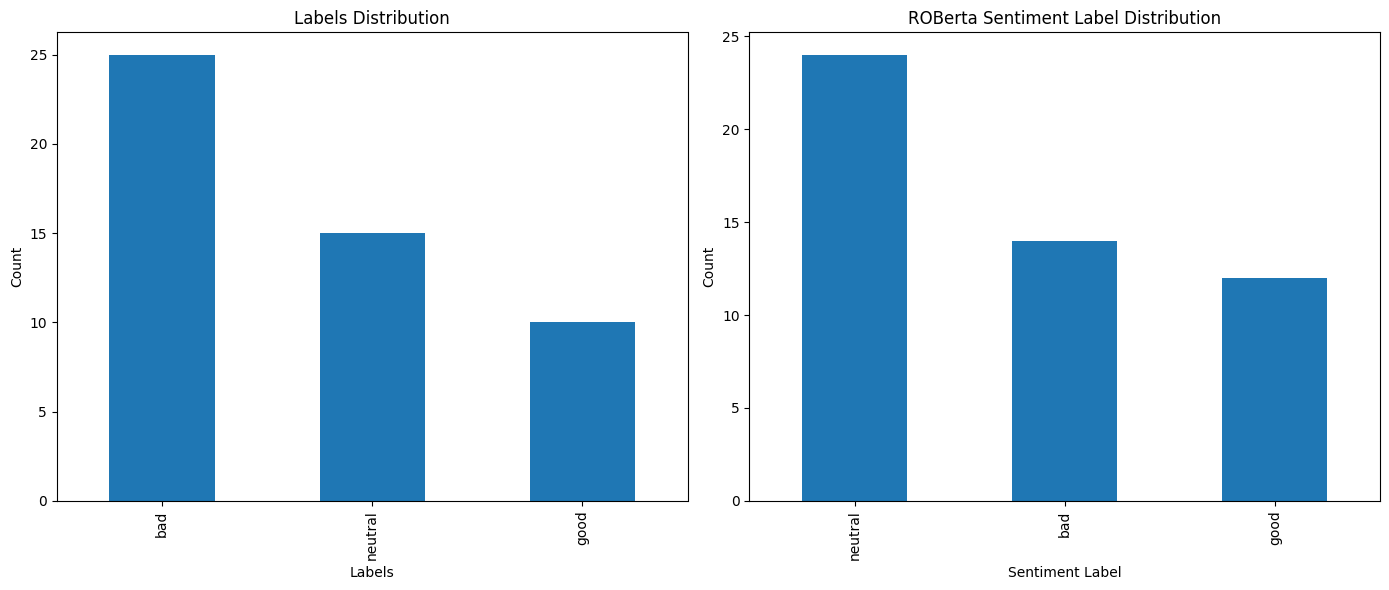

In [41]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot for 'labels' column
data['labels'].value_counts().plot(kind='bar', ax=axes[0], title='Labels Distribution')
axes[0].set_xlabel('Labels')
axes[0].set_ylabel('Count')

# Plot for 'sentiment_label' column
data['sentiment_label'].value_counts().plot(kind='bar', ax=axes[1], title='ROBerta Sentiment Label Distribution')
axes[1].set_xlabel('Sentiment Label')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

- As you can see there ie undeniable difference between teh actual labels we have and Roberata classified labels

- Lets sort this out by `Human Validation`

In [44]:
# Choose a specific tweet
tweet_index = 15  # Change this index to select a different tweet
selected_tweet = data.iloc[tweet_index]

# Display the original sentiment and the predicted sentiment for the selected tweet
print(f"Tweet: {selected_tweet['processed_text']}")
print(f"Original Sentiment: {selected_tweet['labels']}")
print(f"Predicted Sentiment: {selected_tweet['sentiment_label']} (Confidence: {selected_tweet['data_sentiment'][1]:.2f})")

Tweet: ai potenti drive cyber use creat phish email imperson host compani gener vba code emb microsoft excel document infect comput open code download
Original Sentiment: neutral
Predicted Sentiment: bad (Confidence: 0.71)


#### If you played onough with testing how the ROBerta model clasify text againest teh actual labels you willl find that Roberta is actually right in most cases, that makes us go with one of the following options
- Curate the dataset with RoBERTa’s labels and retrain baseline models.
- Use RoBERTa as the main model for sentiment analysis.
- Get human labelers to relabel the dataset.

Each of those options have it's Pros and Cons and you can choose the one you find suitable for your use  case here we will go with RoBERTa as our model as it is already fintuned on the very same usecase of ours and it is already deployed on huggin faces models hub so we can use it's free endpoint for our demo perposes. 

-----

### The whole  code all togither

In [45]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np
import pandas as pd

# Load the model and tokenizer
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
labels = ["bad", "neutral", "good"]

def predict_single_sentiment(text):
    """
    Predict sentiment for a single text input
    Returns: tuple (sentiment, confidence)
    """
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    
    # Get model predictions
    outputs = model(**inputs)
    scores = outputs.logits.detach().numpy()
    probabilities = torch.nn.functional.softmax(torch.tensor(scores), dim=-1)
    
    # Determine the sentiment
    sentiment_index = np.argmax(probabilities.numpy(), axis=1)[0]
    sentiment = labels[sentiment_index]
    confidence = probabilities[0][sentiment_index].item()
    
    return sentiment, confidence

def predict_dataframe_sentiment(df, text_column='processed_text'):
    """
    Predict sentiment for all texts in a DataFrame
    Args:
        df: pandas DataFrame
        text_column: name of the column containing text
    Returns: DataFrame with added sentiment and confidence columns
    """
    # Create new columns for results
    df['sentiment'] = ''
    df['confidence'] = 0.0
    
    # Process each text in the DataFrame
    for idx in df.index:
        text = df.loc[idx, text_column]
        sentiment, confidence = predict_single_sentiment(text)
        df.loc[idx, 'sentiment'] = sentiment
        df.loc[idx, 'confidence'] = confidence
    
    return df

#### Example usage:

In [46]:
# For single text:
sentiment, confidence = predict_single_sentiment("I love this product!")
print(f"Sentiment: {sentiment}, Confidence: {confidence:.2f}")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Sentiment: good, Confidence: 0.99


In [ ]:
# For DataFrame:
data = pd.read_csv(r"D:\AI\NLP\HandsOn\sentiment-analysis\artifacts\feature_transformation\20250116_043222\test_split.csv",index_col=0)
data = data.head(50)
results_df = predict_dataframe_sentiment(data)

In [49]:
results_df.iloc[0]

tweets            How will ChatGPT affect the Web3 space? Indust...
labels                                                          bad
processed_text            chatgpt affect web3 space industri answer
text_length                                                     104
sentiment                                                   neutral
confidence                                                 0.863655
Name: 162912, dtype: object